# Adversarial Attacks on Deep Neural Networks

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Baseline DNN for MINIST dataset

In [2]:
# load dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# design the baseline DNN
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
  #tf.keras.layers.Softmax()
])

# define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

In [4]:
# training
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2408 - accuracy: 0.9295
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1097 - accuracy: 0.9669
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0795 - accuracy: 0.9747
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0625 - accuracy: 0.9807
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0499 - accuracy: 0.9840


In [5]:
# use test data to evaluate the model
result = model.evaluate(x_test,  y_test, verbose=2)
acc1 = result[1]

313/313 - 0s - loss: 0.0666 - accuracy: 0.9794


## FGSM based untargeted attacks

In [6]:
##### perturbation on the test data

# compute the sign of gradient to loss
def grad_sign(x_test, y_test):
  # loss based on y_test and prediction made for x_test
  x_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    output = model(x_tensor)
    loss = loss_fn(y_test, output)
  grad = tape.gradient(loss, x_tensor)
  grad_sign = tf.sign(grad)
  grad_sign = grad_sign.numpy()
  return grad_sign

def perturb(x_test=x_test, y_test=y_test, epsilon=0):
  # FGSM for untargeted perturbation against x_test
  x_p = np.clip(x_test + epsilon * grad_sign(x_test, y_test), 0, 1)
  print('epsilon = {}'.format(epsilon*255))
  plt.figure(figsize=(6,2))
  for id in range(1,4):
    plt.subplot(1,3,id)
    plt.imshow(x_p[id])     # plot some perturbation results
  return x_p

epsilon = 50.0
313/313 - 0s - loss: 11.1192 - accuracy: 0.0267
Success rate:  0.9937717188156604


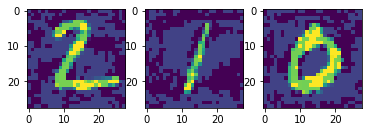

In [7]:
x_p = perturb(epsilon = 50/255)      # do image perturbation, set epsilon = epsilon/255
result = model.evaluate(x_p, y_test, verbose=2)
acc2 = result[1]
rate = (1 - acc2)/acc1      # success rate
print('Success rate: ', rate)

**Report:**

epsilon = 1, Success rate:  0.03

epsilon = 5, Success rate:  0.076

epsilon = 10, Success rate:  0.201

epsilon = 20, Success rate:  0.631

epsilon = 30, Success rate:  0.876

epsilon = 40, Success rate:  0.966

epsilon = 50, Success rate:  0.996




## FGSM based targeted attacks

In [8]:
# construct the target number
y_true = []
for i in range(len(y_test)):
  target = (y_test[i]+1)%10    # get the target number
  y_true.append(target)
y_true = np.array(y_true)

In [9]:
# define targeted perturbation function
def perturb_target(x_test=x_test, y_test=y_true, epsilon=0):
  # FGSM for targeted perturbation against x_test
  x_p = np.clip(x_test - epsilon * grad_sign(x_test, y_true), 0, 1)
  print('epsilon = {}'.format(epsilon*255))
  plt.figure(figsize=(6,2))
  for id in range(1,4):
    plt.subplot(1,3,id)
    plt.imshow(x_p[id])     # plot some perturbation results
  return x_p

epsilon = 50.0
313/313 - 0s - loss: 9.0288 - accuracy: 0.0363
313/313 - 0s - loss: 1.6212 - accuracy: 0.6098
Success rate:  0.6226260916082148


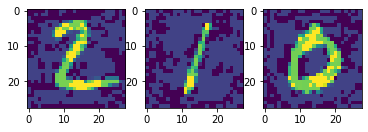

In [10]:
x_p = perturb_target(epsilon = 50/255)  # do image perturbation, set epsilon = epsilon/255

result1 = model.evaluate(x_p, y_test, verbose=2)   # accuracy of prediction to original test labels
result2 = model.evaluate(x_p, y_true, verbose=2)   # accuracy of prediction to targeted labels

acc2 = result1[1]
acc3 = result2[1]
rate = acc3/acc1        # success rate
print('Success rate: ', rate)

**Report:**

epsilon = 1, Success rate:  0.003

epsilon = 5, Success rate:  0.009

epsilon = 10, Success rate:  0.035

epsilon = 20, Success rate:  0.220

epsilon = 30, Success rate:  0.444

epsilon = 40, Success rate:  0.594

epsilon = 50, Success rate:  0.666

## Adversarial Retraining against Untargeted FGSM Attacks

epsilon = 10.0


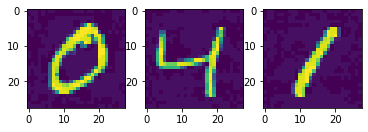

In [11]:
# adversarially perturb the training set and append it to the original training set
x_train_p = perturb(x_test=x_train, y_test=y_train, epsilon = 10/255)
x_train_new = np.concatenate([x_train, x_train_p])
y_train_new = np.concatenate([y_train, y_train])

 ### Adversarially retrained DNN

In [12]:
# design the baseline DNN
model_new = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_new.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

In [13]:
# retraining
model_new.fit(x_train_new, y_train_new, epochs=3)

Epoch 1/3
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1569 - accuracy: 0.9546
Epoch 2/3
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0595 - accuracy: 0.9812
Epoch 3/3
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0412 - accuracy: 0.9868


In [14]:
# use clean test data to evaluate the retrained model
result = model_new.evaluate(x_test, y_test, verbose=2)
acc1 = result[1]

313/313 - 0s - loss: 0.0831 - accuracy: 0.9723


**Report:**

 the classification accuracy of the adversarially retrained DNN on the original clean test dataset is ~0.98

### Examine the robustness of the adversarial retrained DNN against untargeted perturbation

epsilon = 50.0
313/313 - 0s - loss: 0.2273 - accuracy: 0.9714
Success rate:  0.029414766736672343


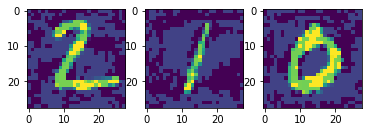

In [15]:
###################### FGSM based untargeted attacks #########################
x_p = perturb(epsilon = 50/255)
result = model_new.evaluate(x_p, y_test, verbose=2)
acc2 = result[1]
rate = (1 - acc2)/acc1      # success rate
print('Success rate: ', rate)

**Report:**

epsilon = 10.0, Success rate:  0.005

epsilon = 100.0, Success rate:  0.083

Adversarially retrained DNN is very robust against adversarial perturbations. When epsilon = 10, the success rate is very small compare to previous baseline DNN. Even when epsilon = 100, the success rate is only 0.083 which is quite small.